### RANSAC

In [171]:
import numpy as np
from typing import Tuple
import matplotlib.pyplot as plt

#### line

In [196]:
class Line:
    """
      A class representing a line in 2D space.

      Attributes:
          x (numpy.ndarray): x-coordinates of line points.
          y (numpy.ndarray): y-coordinates of line points.
          k (float): slope of the line.
          b (float): y-intercept of the line.
    """
    def __init__(self, x: np.ndarray, y: np.ndarray) -> None:
        """
          Initialize a Line object with x and y coordinates of line points.
        """
        self.x = x
        self.y = y
        self.k = None
        self.b = None
        
    def estimate_params(self) -> None:
        """
          Estimates the slope and y-intercept of the line.
        """
        n = len(self.x)
        x_mean = np.mean(self.x)
        y_mean = np.mean(self.y)
        numer = np.sum((self.x - x_mean)*(self.y - y_mean))
        denom = np.sum((self.x - x_mean)**2)
        self.k = numer / denom
        self.b = y_mean - self.k * x_mean
        
    def get_params(self) -> Tuple[float, float]:
        """
          Returns the slope and y-intercept of the line.
        """
        return self.k, self.b
    
    def set_params(self, k: float, b: float) -> None:
        """
          Sets the slope and y-intercept of the line.
        """
        self.k = k
        self.b = b
    
    def divide_points(self, x: np.ndarray, y: np.ndarray, eps: float) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """
          Divides a set of points into inlier and outlier point sets using the estimated line equation.

          Args:
              x (numpy.ndarray): x-coordinates of the set of points.
              y (numpy.ndarray): y-coordinates of the set of points.
              eps (float): maximum distance from a point to the line for it to be considered an inlier.

          Returns:
              A tuple (inliers_x, inliers_y, outliers_x, outliers_y) of inlier and outlier point sets.
        """
        distances = np.abs(y - self.k * x - self.b) / np.sqrt(self.k**2 + 1)
        inliers_mask = distances <= eps
        inliers_x = x[inliers_mask]
        inliers_y = y[inliers_mask]
        outliers_x = x[~inliers_mask]
        outliers_y = y[~inliers_mask]
        return inliers_x, inliers_y, outliers_x, outliers_y

#### ransac

In [203]:
"""
  RANSAC for 2d lines
  Algorythm:

  I Hypotesys generation Stage
  1. Sample 2d points (1. 2 ponts; 2. 5 points)
  2. Model estimation (1. analytics; 2. MSE estimation)

  II Hypotesys evaluation Stage

  3. Inlier counting (%inlinear > threshold) 
      if True -> best params
      if False -> 1.
  4. # iter > num_iter?
"""

class RANSAC:
    def __init__(self):
        """
          Initializes the RANSAC object by setting its default attributes.

          Attributes:
          - iter_num (int): The number of iterations to be performed during the fitting process.
          - n_points (int): The minimum number of points required for a line fitting.
          - inlin_thrsh (float): The inliers threshold value. 
          - epsilon (float): The acceptable deviation from the actual point to the fitting line.
          - best_params (dict): A dictionary containing the best fitting parameters.
          - inlinears_x (list): A list to hold the x-values of the inlying points after fitting.
          - inlinears_y (list): A list to hold the y-values of the inlying points after fitting.
          - outliers_x (list): A list to hold the x-values of the outlier points.
          - outliers_y (list): A list to hold the y-values of the outlier points.
          - score (int): The score of the fitting process.
          - x (numpy.ndarray): The x-values of the input data points.
          - y (numpy.ndarray): The y-values of the input data points.
        """
        self.iter_num: int = 100
        self.n_points: int = 2
        self.inlin_thrsh: float = 0.8
        self.epsilon: float = 0.1
        self.best_params: dict = {}
        self.inlinears_x: list = []
        self.inlinears_y: list = []
        self.outliers_x: list = []
        self.outliers_y: list = []
        self.score: int = 0
        self.x: np.ndarray = None
        self.y: np.ndarray = None
        
    def set_case(self, case_params):
        """
          Set the parameters for the current case.
          
          Parameters:
            case_params: dict
                A dictionary containing the parameters for the current case.
        """
        self.iter_num = case_params.get('iter_num', self.iter_num)
        self.n_points = case_params.get('n_points', self.n_points)
        self.inlin_thrsh = case_params.get('inlin_thrsh', self.inlin_thrsh)
        self.epsilon = case_params.get('epsilon', self.epsilon)
        self.x = case_params['x']
        self.y = case_params['y']
        
    def clear_case(self):
        """
          Clear the parameters of the current case to the initial values.
        """
        self.iter_num: int = 100
        self.n_points: int = 2
        self.inlin_thrsh: float = 0.8
        self.epsilon: float = 0.1
        self.best_params: dict = {}
        self.inlinears_x: list = []
        self.inlinears_y: list = []
        self.outliers_x: list = []
        self.outliers_y: list = []
        self.score: int = 0
        self.x: np.ndarray = None
        self.y: np.ndarray = None
        
    def fit(self):
        """
          Apply the RANSAC algorithm to fit a line to the input points.
        """
        best_score = 0
        for i in range(self.iter_num):
            sample_idxs = np.random.choice(len(self.x), size=self.n_points, replace=False)
            x1, x2 = self.x[sample_idxs[0]], self.x[sample_idxs[1]]
            y1, y2 = self.y[sample_idxs[0]], self.y[sample_idxs[1]]
            if x2 - x1 == 0:
                continue
            a = (y2 - y1) / (x2 - x1)
            b = y1 - a * x1
            inliners_idxs = np.where(np.abs(self.y - (a * self.x + b)) < self.inlin_thrsh)[0]
            if len(inliners_idxs) > self.n_points:
                score = len(inliners_idxs)
                if score > best_score:
                    best_score = score
                    self.best_params['a'] = a
                    self.best_params['b'] = b
                    self.inliners_x = self.x[inliners_idxs]
                    self.inliners_y = self.y[inliners_idxs]
                    self.outliers_x = self.x[np.abs(self.y - (a * self.x + b)) >= self.inlin_thrsh]
                    self.outliers_y = self.y[np.abs(self.y - (a * self.x + b)) >= self.inlin_thrsh]
                    self.score = score
        
    def draw(self):
        """
          Plot the input points with outliers and inliers, and the best fitting line.
        """
        plt.scatter(self.x, self.y, c='b', label='Input points')
        plt.scatter(self.outliers_x, self.outliers_y, c='r', label='Outliers')
        plt.scatter(self.inliners_x, self.inliners_y, c='g', label='Inliers')
        xs = np.arange(self.x.min(), self.x.max(), 0.1)
        if self.best_params['a'] is not None and self.best_params['b'] is not None:
            plt.plot(xs, self.best_params['a'] * xs + self.best_params['b'], '-k',
                     label='Fitted line (score=%.2f)' % self.score)
        plt.legend(loc='best')
        plt.title(f"RANSAC ({self.n_points} samples)")
        plt.show()

#### data

In [184]:
"""
  Data generation module.
"""

class Point_Generator():
    """A class for generating points with inliers and outliers"""
    def __init__(self, num_points: int, percent_outliers: float) -> None:
        """
          Initialize the Point_Generator object
          
          Parameters:
              num_points (int): The total number of points to generate
              percent_outliers (float): The percentage of the total number of points to be outliers
        """
        self.num_points = num_points
        self.percent_outliers = percent_outliers
        self.inliers_num = int(np.floor(self.num_points * (1 - self.percent_outliers)))
        self.outliers_num = num_points - self.inliers_num
    
    def generate_case(self, k: float = 1., b: float = 0., eps: float = 0.1) -> np.ndarray:
        """
            Generate points with inliers and outliers. 
            
            Parameters:
                k (float): The slope of the line
                b (float): The intercept of the line
                eps (float): The scale of the noise added to inliers
                
            Returns:
                np.ndarray: An array of generated points
        """
        if k is None:
            k = np.random.uniform(-1, 1)
        if b is None:
            b = np.random.uniform(0, 5)

        x = np.linspace(0, 10, self.inliers_num)
        y = k * x + b + np.random.normal(scale=eps, size = len(x))
        inliers = np.vstack((x,y)).T

        x = np.random.uniform(0, 10, self.outliers_num)
        y = np.random.uniform(y.min(), y.max(), self.outliers_num)
        outliers = np.vstack((x,y)).T
        
        data = np.concatenate((inliers, outliers))
        np.random.shuffle(data)

        return data.T[0], data.T[1]

#### main

In [215]:
def main():
    point_generator = Point_Generator(100, 0.3)
    x, y = point_generator.generate_case(None, None, eps=0.1)

    line = Line(x, y)
    line.estimate_params()
    inliers_x, inliers_y, outliers_x, outliers_y = line.divide_points(x, y, eps = 0.1)
    k, b = line.get_params()

    plt.rcParams["figure.figsize"] = (7,3)
    plt.plot(inliers_x, inliers_y, 'o', c='g', label='inliers')
    plt.plot(outliers_x, outliers_y, 'o', c='r', label='outliers')
    plt.plot(x, k * x + b, 'r', label='Fitted line')
    plt.title("No RANSAC")
    plt.legend()
    plt.show()

    ransac = RANSAC()
    case_params = {'x': x, 'y': y}
    ransac.set_case(case_params)
    ransac.fit()
    ransac.draw()

    ransac = RANSAC()
    case_params = {'x': x, 'y': y, 'n_points': 5}
    ransac.set_case(case_params)
    ransac.fit()
    ransac.draw()

### Применение

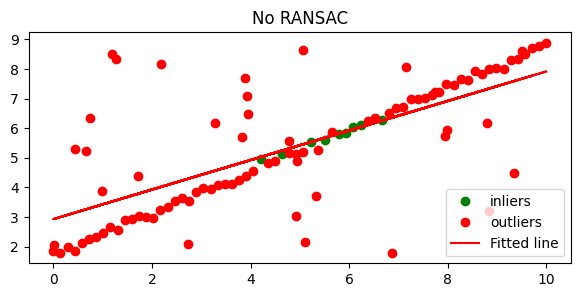

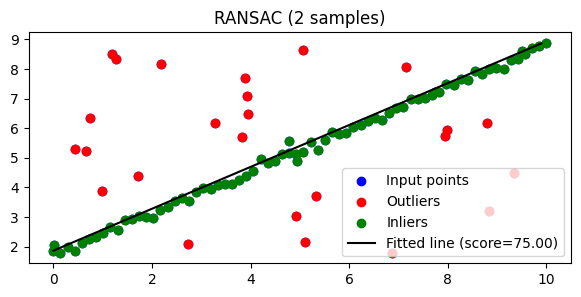

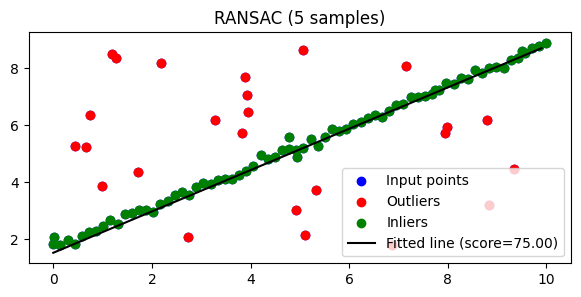

In [216]:
main()